<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM_GRU/LSTM_GRU_Nvidia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 4.45 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Jul 19 11:38:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Nvidia'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM_GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 9.3MB/s 
     |████████████████████████████████| 174kB 33.7MB/s 
     |████████████████████████████████| 143kB 35.4MB/s 
     |████████████████████████████████| 102kB 10.2MB/s 
     |████████████████████████████████| 143kB 21.6MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'dropout': 0.2,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(LSTM(units=64, activation=config.activation, return_sequences=True, input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(GRU(units=64, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 3
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: s5xopigt
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM_GRU/sweeps/s5xopigt


In [16]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: fube4lq0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 6s 49ms/step - loss: 0.0467 - mean_squared_error: 0.0467 - mean_absolute_error: 0.1318 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0958
Epoch 2/50
31/31 [==============================] - 0s 11ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0239 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0654
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0205 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0720
Epoch 4/50
31/31 [==============================] - 0s 12ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0186 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0643
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 8.5881e-04 - mean_squared_e

epoch,49
loss,0.00067
mean_squared_error,0.00067
mean_absolute_error,0.01415
val_loss,0.00514
val_mean_squared_error,0.00514
val_mean_absolute_error,0.05091
_runtime,29
_timestamp,1626700290
_step,49
best_val_loss,0.00498


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▆▄▅▃▄▃▄▃▃▄▂▃▃▃▂▂▂▃▂▃▂▂▂▂▂▄▂▁▁▁▁▁▁▂▁▁▂▁
val_mean_squared_error,█▄▆▄▅▃▄▃▄▃▃▄▂▃▃▃▂▂▂▃▂▃▂▂▂▂▂▄▂▁▁▁▁▁▁▂▁▁▂▁
val_mean_absolute_error,█▃▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▃▁▂▁▁▁▁▁▂▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8xtc0zej with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 8s 366ms/step - loss: 0.0556 - mean_squared_error: 0.0556 - mean_absolute_error: 0.1401 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1080
Epoch 2/50
8/8 [==============================] - 2s 213ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0448 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1016
Epoch 3/50
8/8 [==============================] - 2s 200ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0357 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1164
Epoch 4/50
8/8 [==============================] - 2s 186ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0404 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0929
Epoch 5/50
8/8 [==============================] - 1s 180ms/step - loss: 0.0043 - mean_squared_error: 0.0

epoch,49
loss,0.00082
mean_squared_error,0.00082
mean_absolute_error,0.01636
val_loss,0.00636
val_mean_squared_error,0.00636
val_mean_absolute_error,0.05617
_runtime,87
_timestamp,1626700384
_step,49
best_val_loss,0.00575


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▇█▅▅▄▇▃▄▃▃▂▃▂▂▂▂▂▂▃▂▂▂▃▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁
val_mean_squared_error,▆▇█▅▅▄▇▃▄▃▃▂▃▂▂▂▂▂▂▃▂▂▂▃▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁
val_mean_absolute_error,▇▆█▅▅▄█▄▄▃▃▃▄▃▃▂▂▂▂▃▂▂▂▄▄▁▂▁▁▁▁▃▁▂▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4oiot8ky with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 12s 228ms/step - loss: 0.0788 - mean_squared_error: 0.0788 - mean_absolute_error: 0.1711 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1396
Epoch 2/50
31/31 [==============================] - 6s 187ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0539 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0827
Epoch 3/50
31/31 [==============================] - 5s 176ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0313 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0663
Epoch 4/50
31/31 [==============================] - 6s 185ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0248 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0647
Epoch 5/50
31/31 [==============================] - 6s 186ms/step - loss: 0.0023 - mean_squared

epoch,40
loss,0.00099
mean_squared_error,0.00099
mean_absolute_error,0.01908
val_loss,0.00655
val_mean_squared_error,0.00655
val_mean_absolute_error,0.05683
_runtime,244
_timestamp,1626700642
_step,40
best_val_loss,0.00599


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▂▂▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▂▂▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▂▁▂▁▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▂▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: u6dsnbvi with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 8s 369ms/step - loss: 0.1282 - mean_squared_error: 0.1282 - mean_absolute_error: 0.2230 - val_loss: 0.3664 - val_mean_squared_error: 0.3664 - val_mean_absolute_error: 0.5643
Epoch 2/200
8/8 [==============================] - 2s 186ms/step - loss: 0.1002 - mean_squared_error: 0.1002 - mean_absolute_error: 0.1965 - val_loss: 0.2542 - val_mean_squared_error: 0.2542 - val_mean_absolute_error: 0.4664
Epoch 3/200
8/8 [==============================] - 2s 194ms/step - loss: 0.0615 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1642 - val_loss: 0.1308 - val_mean_squared_error: 0.1308 - val_mean_absolute_error: 0.3342
Epoch 4/200
8/8 [==============================] - 1s 169ms/step - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.1441 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1457
Epoch 5/200
8/8 [==============================] - 1s 181ms/step - loss: 0.0157 - mean_squared_error

epoch,69
loss,0.00094
mean_squared_error,0.00094
mean_absolute_error,0.01716
val_loss,0.007
val_mean_squared_error,0.007
val_mean_absolute_error,0.05986
_runtime,116
_timestamp,1626700770
_step,69
best_val_loss,0.0064


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: i8fkase4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)


Epoch 1/50
8/8 [==============================] - 6s 189ms/step - loss: 0.0846 - mean_squared_error: 0.0846 - mean_absolute_error: 0.1811 - val_loss: 0.0363 - val_mean_squared_error: 0.0363 - val_mean_absolute_error: 0.1678
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.1148 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1297
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0471 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0879
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0292 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0590
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0018 - mean_squared_error: 0.0018 

epoch,24
loss,0.00099
mean_squared_error,0.00099
mean_absolute_error,0.01741
val_loss,0.00707
val_mean_squared_error,0.00707
val_mean_absolute_error,0.05877
_runtime,15
_timestamp,1626700808
_step,24
best_val_loss,0.00648


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆▆██████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆▆██████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: tv1tskxq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 7s 92ms/step - loss: 0.0371 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1097 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0686
Epoch 2/200
16/16 [==============================] - 0s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0378 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0550
Epoch 3/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0258 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0717
Epoch 4/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0398 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0544
Epoch 5/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0013 - mean_squared_

epoch,19
loss,0.0013
mean_squared_error,0.0013
mean_absolute_error,0.02383
val_loss,0.00558
val_mean_squared_error,0.00558
val_mean_absolute_error,0.05964
_runtime,16
_timestamp,1626700830
_step,19
best_val_loss,0.0048


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▂▁▁▂▂▂▂▁▁▁▂▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▂▂▂▂▁▁▁▂▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▃▃▃▃▂▂▁▃▂▂▂▂▁▂
val_loss,▁▁▁▁▂▁▁█▂▁▁▂▁▂▁▂▁▁▁▁
val_mean_squared_error,▁▁▁▁▂▁▁█▂▁▁▂▁▂▁▂▁▁▁▁
val_mean_absolute_error,▂▁▂▁▂▁▁█▃▁▁▂▁▂▂▃▂▂▁▂
_runtime,▁▁▁▂▂▂▄▄▄▄▅▅▅▅▇▇▇███
_timestamp,▁▁▁▂▂▂▄▄▄▄▅▅▅▅▇▇▇███
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: pc3z5xo5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 6s 88ms/step - loss: 0.0635 - mean_squared_error: 0.0635 - mean_absolute_error: 0.1522 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0996
Epoch 2/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0289 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0818
Epoch 3/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0223 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0911
Epoch 4/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0259 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1309
Epoch 5/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0024 - mean_squared_

epoch,182
loss,0.00069
mean_squared_error,0.00069
mean_absolute_error,0.01694
val_loss,0.00632
val_mean_squared_error,0.00632
val_mean_absolute_error,0.06251
_runtime,51
_timestamp,1626700890
_step,182
best_val_loss,0.00318


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▅▅▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
mean_squared_error,█▅▅▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
mean_absolute_error,█▆▆▅▃▃▃▃▂▃▂▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▂▁▂▂▁▂▁
val_loss,█▅▅▄▃▅▆▄▃▂▂▃▂▂▂▃▃▂▂▂▃▂▆▁▂▂▁▁▁▂▂▃▁▁▂▁▁▁▁▁
val_mean_squared_error,█▅▅▄▃▅▆▄▃▂▂▃▂▂▂▃▃▂▂▂▃▂▆▁▂▂▁▁▁▂▂▃▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▆▇▆▃▃▃▄▃▄▃▄▃▃▃▂▅▂█▂▂▂▂▂▁▃▂▄▂▂▂▂▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: pexrm77z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 6s 181ms/step - loss: 0.0563 - mean_squared_error: 0.0563 - mean_absolute_error: 0.1382 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0696
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0322 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1142
Epoch 3/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0435 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0824
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0278 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0808
Epoch 5/50
8/8 [==============================] - 0s 20ms/step - loss: 0.0022 - mean_squared_error: 0.0022 

epoch,49
loss,0.00136
mean_squared_error,0.00136
mean_absolute_error,0.02353
val_loss,0.00913
val_mean_squared_error,0.00913
val_mean_absolute_error,0.08178
_runtime,17
_timestamp,1626700915
_step,49
best_val_loss,0.00459


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▃▂▂▂▂▂▂▁▂▁▂▂▁▂▁▂▁▂▂▂▁▂▁▂▁▂▁▁▁▂▁▁▂▂▁
val_loss,▃█▅▄▂▄▂▆▄▂▄▂▂▂▂▂▃▃▂▁▂▃▂▂▂▃▁▂▁▁▁▂▁▁▂▁▂▁▁▃
val_mean_squared_error,▃█▅▄▂▄▂▆▄▂▄▂▂▂▂▂▃▃▂▁▂▃▂▂▂▃▁▂▁▁▁▂▁▁▂▁▂▁▁▃
val_mean_absolute_error,▃█▅▄▃▆▂▇▅▂▆▂▂▂▂▂▄▅▂▁▂▄▃▃▂▃▁▃▂▁▂▃▂▁▂▁▂▁▁▅
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xkq1eyvo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 8s 257ms/step - loss: 0.1334 - mean_squared_error: 0.1334 - mean_absolute_error: 0.2272 - val_loss: 0.2678 - val_mean_squared_error: 0.2678 - val_mean_absolute_error: 0.4788
Epoch 2/100
16/16 [==============================] - 3s 185ms/step - loss: 0.0580 - mean_squared_error: 0.0580 - mean_absolute_error: 0.1631 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1906
Epoch 3/100
16/16 [==============================] - 3s 178ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - mean_absolute_error: 0.1288 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.1070
Epoch 4/100
16/16 [==============================] - 3s 185ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0544 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0649
Epoch 5/100
16/16 [==============================] - 3s 190ms/step - loss: 0.0027 - mean_squ

epoch,46
loss,0.00118
mean_squared_error,0.00118
mean_absolute_error,0.02073
val_loss,0.00812
val_mean_squared_error,0.00812
val_mean_absolute_error,0.06317
_runtime,148
_timestamp,1626701073
_step,46
best_val_loss,0.00722


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: nqy7jja9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 9s 370ms/step - loss: 0.0766 - mean_squared_error: 0.0766 - mean_absolute_error: 0.1726 - val_loss: 0.0546 - val_mean_squared_error: 0.0546 - val_mean_absolute_error: 0.2129
Epoch 2/50
8/8 [==============================] - 2s 192ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0560 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0691
Epoch 3/50
8/8 [==============================] - 2s 195ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0249 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0722
Epoch 4/50
8/8 [==============================] - 1s 176ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0247 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0625
Epoch 5/50
8/8 [==============================] - 2s 190ms/step - loss: 0.0016 - mean_squared_error: 0.0

epoch,49
loss,0.00186
mean_squared_error,0.00186
mean_absolute_error,0.02818
val_loss,0.00797
val_mean_squared_error,0.00797
val_mean_absolute_error,0.06679
_runtime,91
_timestamp,1626701180
_step,49
best_val_loss,0.00529


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▂▃▂▂▂▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▂▁
val_loss,█▂▁▁▁▆▃▁▃▂▁▂▁▁▁▃▂▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▆▃▁▃▂▁▂▁▁▁▃▂▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▁▂▆▄▂▄▂▁▃▁▂▂▄▂▁▁▂▁▁▁▁▂▁▂▂▂▂▁▁▁▁▁▁▁▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 9pyjvql5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 9s 261ms/step - loss: 0.0620 - mean_squared_error: 0.0620 - mean_absolute_error: 0.1474 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1411
Epoch 2/100
16/16 [==============================] - 3s 201ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0356 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0706
Epoch 3/100
16/16 [==============================] - 3s 193ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0276 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0594
Epoch 4/100
16/16 [==============================] - 3s 180ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0235 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0595
Epoch 5/100
16/16 [==============================] - 3s 163ms/step - loss: 0.0017 - mean_squ

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [17]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 64,
    'learning_rate': 0.005,
    'dropout': 0.1,
    'optimizer': 'nadam',
    'activation': 'tanh'
}

In [18]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(LSTM(units=64, activation=best_config['activation'], return_sequences=True, input_shape=(window_len, 1)))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(GRU(units=64, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 3
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  41921


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            16896     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
gru (GRU)                    (None, 64)                24960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 41,921
Trainable params: 41,921
Non-trainable params: 0
_________________________________________________________________


In [20]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
20/20 [==============================] - 5s 10ms/step - loss: 0.0554
Epoch 2/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0029
Epoch 3/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 4/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0029
Epoch 5/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0017
Epoch 6/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0014
Epoch 7/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0032
Epoch 8/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0018
Epoch 9/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0018
Epoch 10/100
20/20 [==============================] - 0s 11ms/step - loss: 0.0013
Epoch 11/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0020
Epoch 12/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 13/100
20/20 [=====

In [21]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

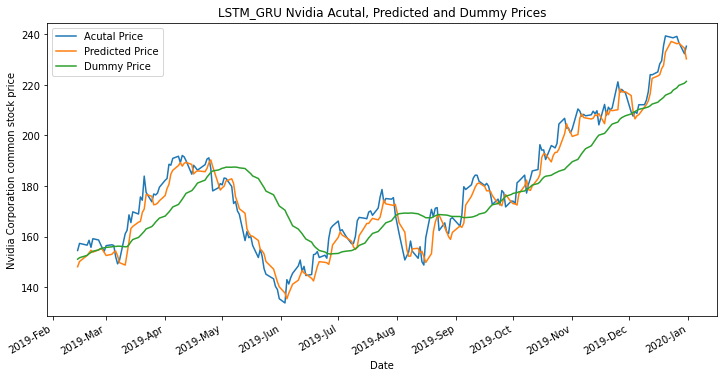

In [22]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

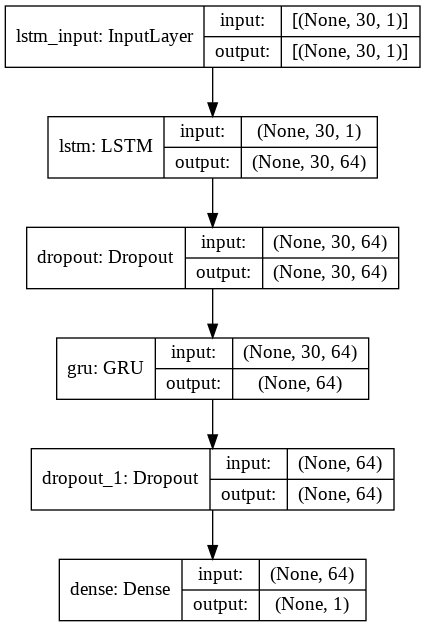

In [23]:
plot_model(model, show_shapes=True, expand_nested=True)

In [24]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0019642852857902075
RMSE:  0.04432025818731438
MAE:  0.033418108659003076
Dummy MSE:  0.01623808785220405
Dummy RMSE:  0.12742875598625314
Dummy MAE:  0.10320580289003882


In [25]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_GRU_Nvidia/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_GRU_Nvidia/assets
